In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/birds-20-species-image-classification/images to predict/6.jpg
/kaggle/input/birds-20-species-image-classification/images to predict/5.jpg
/kaggle/input/birds-20-species-image-classification/images to predict/1.jpg
/kaggle/input/birds-20-species-image-classification/images to predict/4.jpg
/kaggle/input/birds-20-species-image-classification/images to predict/3.jpg
/kaggle/input/birds-20-species-image-classification/images to predict/2.jpg
/kaggle/input/birds-20-species-image-classification/valid/AMERICAN KESTREL/5.jpg
/kaggle/input/birds-20-species-image-classification/valid/AMERICAN KESTREL/1.jpg
/kaggle/input/birds-20-species-image-classification/valid/AMERICAN KESTREL/4.jpg
/kaggle/input/birds-20-species-image-classification/valid/AMERICAN KESTREL/3.jpg
/kaggle/input/birds-20-species-image-classification/valid/AMERICAN KESTREL/2.jpg
/kaggle/input/birds-20-species-image-classification/valid/AMERICAN GOLDFINCH/5.jpg
/kaggle/input/birds-20-species-image-classification/vali

In [35]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm
import random
from torch.utils.data import Subset, DataLoader

In [4]:
# Set device (GPU if available, else CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [5]:
# Define data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  # Resize and randomly crop to 224x224
        transforms.RandomHorizontalFlip(),  # Data augmentation: random flip
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet means and stds
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),  # Resize to 256x256
        transforms.CenterCrop(224),  # Center crop to 224x224
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [8]:
# Load the dataset
data_dir = '/kaggle/input/birds-20-species-image-classification'  # Update this path to where you extracted the dataset
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['train', 'valid', 'test']
}

In [9]:
# Create a subset of 2,000 training images
num_images_per_class = 100  # 2,000 images ÷ 20 classes
train_dataset = image_datasets['train']
class_indices = train_dataset.targets  # List of class labels for each image
class_names = train_dataset.classes
num_classes = len(class_names)

In [10]:
# Collect indices for each class
indices_per_class = [[] for _ in range(num_classes)]
for idx, label in enumerate(class_indices):
    indices_per_class[label].append(idx)

In [11]:
# Randomly select 100 images per class
subset_indices = []
for class_idx in range(num_classes):
    selected_indices = random.sample(indices_per_class[class_idx], min(num_images_per_class, len(indices_per_class[class_idx])))
    subset_indices.extend(selected_indices)

In [12]:
# Create subset dataset
image_datasets['train'] = Subset(train_dataset, subset_indices)

In [13]:
# Create data loaders
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=4),
    'valid': torch.utils.data.DataLoader(image_datasets['valid'], batch_size=32, shuffle=False, num_workers=4),
    'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=4)
}

In [14]:
# Get dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
print(f"Number of classes: {num_classes}")
print(f"Dataset sizes: {dataset_sizes}")

Number of classes: 20
Dataset sizes: {'train': 2000, 'valid': 100, 'test': 100}


In [15]:
# Load pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 198MB/s]


In [16]:
# Freeze all layers except the final fully connected layer
for param in model.parameters():
    param.requires_grad = False

In [17]:
# Replace the final fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

In [18]:
# Move model to device
model = model.to(device)

In [19]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

In [20]:
# Learning rate scheduler (reduce LR by factor of 0.1 every 7 epochs)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [21]:
# Training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluation mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in tqdm(dataloaders[phase], desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass and optimize only in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model if validation accuracy improves
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [22]:
# Train the model
model = train_model(model, criterion, optimizer, scheduler, num_epochs=25)

Epoch 0/24
----------


train: 100%|██████████| 63/63 [00:08<00:00,  7.83it/s]


train Loss: 2.5740 Acc: 0.3405


valid: 100%|██████████| 4/4 [00:00<00:00,  6.04it/s]


valid Loss: 1.7339 Acc: 0.7800

Epoch 1/24
----------


train: 100%|██████████| 63/63 [00:06<00:00,  9.21it/s]


train Loss: 1.6869 Acc: 0.7375


valid: 100%|██████████| 4/4 [00:00<00:00,  6.69it/s]


valid Loss: 0.9814 Acc: 0.9200

Epoch 2/24
----------


train: 100%|██████████| 63/63 [00:06<00:00,  9.27it/s]


train Loss: 1.2558 Acc: 0.7970


valid: 100%|██████████| 4/4 [00:00<00:00,  6.91it/s]


valid Loss: 0.6576 Acc: 0.9500

Epoch 3/24
----------


train: 100%|██████████| 63/63 [00:06<00:00,  9.21it/s]


train Loss: 1.0198 Acc: 0.8415


valid: 100%|██████████| 4/4 [00:00<00:00,  6.93it/s]


valid Loss: 0.5395 Acc: 0.9300

Epoch 4/24
----------


train: 100%|██████████| 63/63 [00:06<00:00,  9.10it/s]


train Loss: 0.8863 Acc: 0.8480


valid: 100%|██████████| 4/4 [00:00<00:00,  6.95it/s]


valid Loss: 0.4088 Acc: 0.9400

Epoch 5/24
----------


train: 100%|██████████| 63/63 [00:06<00:00,  9.10it/s]


train Loss: 0.7993 Acc: 0.8450


valid: 100%|██████████| 4/4 [00:00<00:00,  6.34it/s]


valid Loss: 0.3663 Acc: 0.9500

Epoch 6/24
----------


train: 100%|██████████| 63/63 [00:06<00:00,  9.06it/s]


train Loss: 0.7196 Acc: 0.8635


valid: 100%|██████████| 4/4 [00:00<00:00,  6.68it/s]


valid Loss: 0.2984 Acc: 0.9600

Epoch 7/24
----------


train: 100%|██████████| 63/63 [00:07<00:00,  8.99it/s]


train Loss: 0.6839 Acc: 0.8635


valid: 100%|██████████| 4/4 [00:00<00:00,  6.45it/s]


valid Loss: 0.2930 Acc: 0.9600

Epoch 8/24
----------


train: 100%|██████████| 63/63 [00:07<00:00,  8.86it/s]


train Loss: 0.6663 Acc: 0.8790


valid: 100%|██████████| 4/4 [00:00<00:00,  6.68it/s]


valid Loss: 0.2928 Acc: 0.9600

Epoch 9/24
----------


train: 100%|██████████| 63/63 [00:07<00:00,  8.82it/s]


train Loss: 0.6844 Acc: 0.8670


valid: 100%|██████████| 4/4 [00:00<00:00,  6.74it/s]


valid Loss: 0.2826 Acc: 0.9600

Epoch 10/24
----------


train: 100%|██████████| 63/63 [00:07<00:00,  8.77it/s]


train Loss: 0.6666 Acc: 0.8795


valid: 100%|██████████| 4/4 [00:00<00:00,  6.53it/s]


valid Loss: 0.2876 Acc: 0.9500

Epoch 11/24
----------


train: 100%|██████████| 63/63 [00:07<00:00,  8.70it/s]


train Loss: 0.6829 Acc: 0.8685


valid: 100%|██████████| 4/4 [00:00<00:00,  6.62it/s]


valid Loss: 0.2824 Acc: 0.9600

Epoch 12/24
----------


train: 100%|██████████| 63/63 [00:07<00:00,  8.57it/s]


train Loss: 0.6689 Acc: 0.8710


valid: 100%|██████████| 4/4 [00:00<00:00,  6.66it/s]


valid Loss: 0.2645 Acc: 0.9700

Epoch 13/24
----------


train: 100%|██████████| 63/63 [00:07<00:00,  8.51it/s]


train Loss: 0.6504 Acc: 0.8745


valid: 100%|██████████| 4/4 [00:00<00:00,  6.80it/s]


valid Loss: 0.2870 Acc: 0.9500

Epoch 14/24
----------


train: 100%|██████████| 63/63 [00:07<00:00,  8.44it/s]


train Loss: 0.6547 Acc: 0.8790


valid: 100%|██████████| 4/4 [00:00<00:00,  6.50it/s]


valid Loss: 0.2755 Acc: 0.9700

Epoch 15/24
----------


train: 100%|██████████| 63/63 [00:07<00:00,  8.34it/s]


train Loss: 0.6481 Acc: 0.8815


valid: 100%|██████████| 4/4 [00:00<00:00,  6.38it/s]


valid Loss: 0.2731 Acc: 0.9600

Epoch 16/24
----------


train: 100%|██████████| 63/63 [00:07<00:00,  8.24it/s]


train Loss: 0.6476 Acc: 0.8745


valid: 100%|██████████| 4/4 [00:00<00:00,  6.48it/s]


valid Loss: 0.2728 Acc: 0.9600

Epoch 17/24
----------


train: 100%|██████████| 63/63 [00:07<00:00,  8.21it/s]


train Loss: 0.6342 Acc: 0.8880


valid: 100%|██████████| 4/4 [00:00<00:00,  6.37it/s]


valid Loss: 0.2829 Acc: 0.9600

Epoch 18/24
----------


train: 100%|██████████| 63/63 [00:07<00:00,  8.09it/s]


train Loss: 0.6269 Acc: 0.8830


valid: 100%|██████████| 4/4 [00:00<00:00,  6.44it/s]


valid Loss: 0.2722 Acc: 0.9600

Epoch 19/24
----------


train: 100%|██████████| 63/63 [00:07<00:00,  7.98it/s]


train Loss: 0.6700 Acc: 0.8645


valid: 100%|██████████| 4/4 [00:00<00:00,  6.20it/s]


valid Loss: 0.2745 Acc: 0.9600

Epoch 20/24
----------


train: 100%|██████████| 63/63 [00:07<00:00,  7.95it/s]


train Loss: 0.6567 Acc: 0.8785


valid: 100%|██████████| 4/4 [00:00<00:00,  6.15it/s]


valid Loss: 0.2703 Acc: 0.9600

Epoch 21/24
----------


train: 100%|██████████| 63/63 [00:07<00:00,  7.91it/s]


train Loss: 0.6271 Acc: 0.8860


valid: 100%|██████████| 4/4 [00:00<00:00,  6.13it/s]


valid Loss: 0.2616 Acc: 0.9700

Epoch 22/24
----------


train: 100%|██████████| 63/63 [00:08<00:00,  7.72it/s]


train Loss: 0.6464 Acc: 0.8750


valid: 100%|██████████| 4/4 [00:00<00:00,  6.37it/s]


valid Loss: 0.2725 Acc: 0.9700

Epoch 23/24
----------


train: 100%|██████████| 63/63 [00:08<00:00,  7.73it/s]


train Loss: 0.6559 Acc: 0.8755


valid: 100%|██████████| 4/4 [00:00<00:00,  5.99it/s]


valid Loss: 0.2704 Acc: 0.9600

Epoch 24/24
----------


train: 100%|██████████| 63/63 [00:08<00:00,  7.83it/s]


train Loss: 0.6691 Acc: 0.8550


valid: 100%|██████████| 4/4 [00:00<00:00,  6.25it/s]

valid Loss: 0.2716 Acc: 0.9700

Training complete in 3m 22s
Best val Acc: 0.9700


In [23]:
# Evaluate the model on the test set
def evaluate_model(model, dataloader):
    model.eval()
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Test"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

    test_acc = running_corrects.double() / dataset_sizes['test']
    print(f'Test Accuracy: {test_acc:.4f}')

In [24]:
# Evaluate on test set
evaluate_model(model, dataloaders['test'])

Test: 100%|██████████| 4/4 [00:00<00:00,  5.17it/s]

Test Accuracy: 0.9800


In [25]:
torch.save(model.state_dict(), 'bird_classifier_resnet50_subset.pth')

In [30]:
from PIL import Image
import numpy as np

In [31]:
# Function to predict and visualize random test images
def predict_random_images(model, dataset, transform, class_names, num_images=5):
    model.eval()
    # Randomly select indices from the test dataset
    indices = random.sample(range(len(dataset)), min(num_images, len(dataset)))
    
    # Create a temporary DataLoader for selected images
    subset_dataset = Subset(dataset, indices)
    dataloader = DataLoader(subset_dataset, batch_size=1, shuffle=False)
    
    plt.figure(figsize=(15, 3 * num_images))
    for idx, (image, label) in enumerate(tqdm(dataloader, desc="Predicting random images")):
        image = image.to(device)
        true_label = class_names[label.item()]

        # Predict
        with torch.no_grad():
            outputs = model(image)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            confidence, predicted = torch.max(probabilities, 1)
            predicted_class = class_names[predicted.item()]
            confidence_score = confidence.item()

        # Denormalize image for visualization
        img = image.squeeze().cpu().numpy().transpose(1, 2, 0)
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)

        # Plot image with prediction
        plt.subplot(num_images, 1, idx + 1)
        plt.imshow(img)
        plt.title(f"Predicted: {predicted_class} (Confidence: {confidence_score:.4f})\nTrue: {true_label}")
        plt.axis('off')

        # Print prediction
        print(f"Image {idx + 1}: Predicted: {predicted_class} (Confidence: {confidence_score:.4f}), True: {true_label}")
    
    plt.tight_layout()
    plt.show()

In [32]:
model_path = 'bird_classifier_resnet50_subset.pth'

In [33]:
# Set model to evaluation mode
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 


Predicting on 5 random test images:


Predicting random images:  20%|██        | 1/5 [00:00<00:00,  8.29it/s]

Image 1: Predicted: AFRICAN PYGMY GOOSE (Confidence: 0.6096), True: AFRICAN PYGMY GOOSE
Image 2: Predicted: ALBATROSS (Confidence: 0.9607), True: ALBATROSS
Image 3: Predicted: ABYSSINIAN GROUND HORNBILL (Confidence: 0.8032), True: ABYSSINIAN GROUND HORNBILL


Predicting random images: 100%|██████████| 5/5 [00:00<00:00, 20.39it/s]

Image 4: Predicted: ABBOTTS BABBLER (Confidence: 0.3735), True: ABBOTTS BABBLER
Image 5: Predicted: ALBATROSS (Confidence: 0.9386), True: ALBATROSS


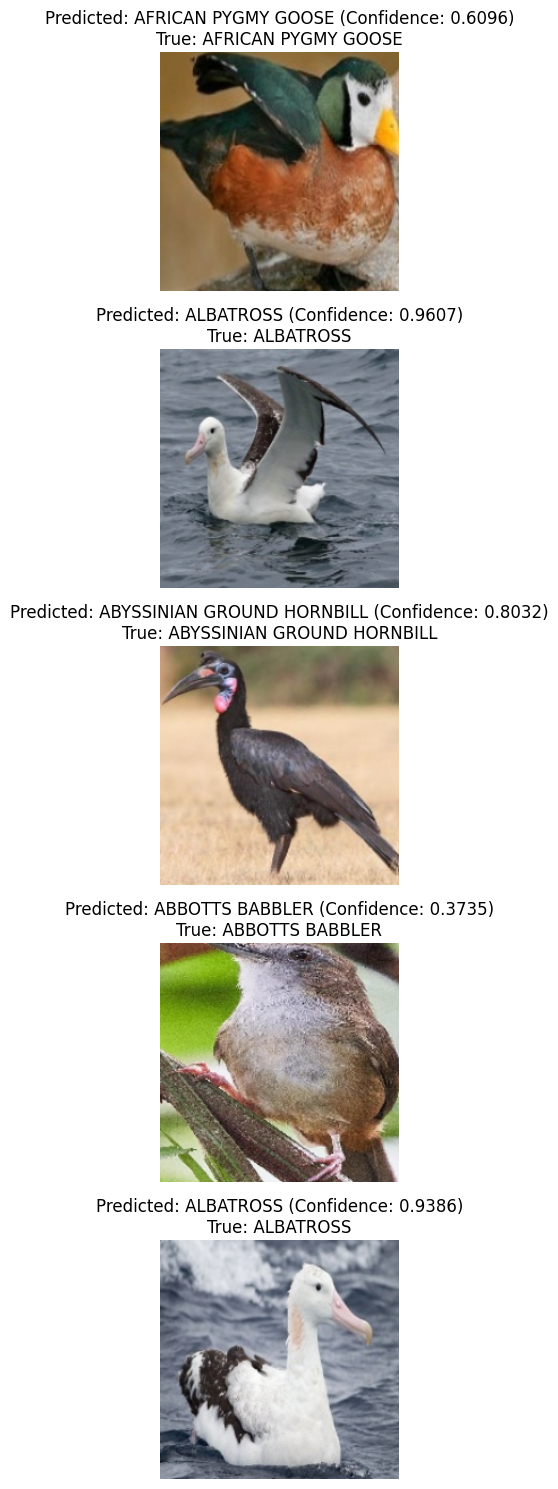

In [36]:
# Predict and visualize 5 random test images
print("\nPredicting on 5 random test images:")
predict_random_images(model, image_datasets['test'], data_transforms['test'], class_names, num_images=5)